### Enigma Machine

恩尼格玛密码机是一种用于加密/解密的密码机，在二战时期纳粹德国广泛使用。

恩尼格玛密码机结合了计息系统和电子系统，核心原理是通过不同的转子组合、转子初始状态、接线板连接等，构成不同的按键映射电路，同时转子本身按照一定的按键周期转动（进一步打乱电路，重复输>入同一个字母会输出不一样的加密结果）

解密的时候对方只将密码机的初始状态设置到与加密方一样，然后输入加密的信息，就会产出解密后的信息。因为是通过电路回路来实现字母的映射，假如输入 A 加密得到 B，那么在相同的密码机状态下输
入 B 加密能够得到 A。

只要通讯双方约定好相同的配置（包括转子选择、转子初始状态、接线板连接方式等），即可以实现信息的加解密。

#### 恩尼格码密码机破译

恩尼格码密码机的一个特点是一个字母加密之后的密文一定不会是这个字母本身（否则无法构成回路），因此当时破译者先是猜测可能出现在密文中的一个词语 (Heil Hitler)，然后将这个词语放到密文中 >，滑动进行匹配，如果发现有字母完全不相同的，那么这个密文就可能是这个词语的加密。然后根据这组明文密文对，逐一尝试各种配置方式。

#### links
- https://zh.wikipedia.org/wiki/%E6%81%A9%E5%B0%BC%E6%A0%BC%E7%8E%9B%E5%AF%86%E7%A0%81%E6%9C%BA
- https://www.matematiksider.dk/enigma/enigma_circuit_big.png
- https://web.stanford.edu/class/cs106j/handouts/36-TheEnigmaMachine.pdf
- https://www.cryptomuseum.com/crypto/enigma/wiring.htm#12
- https://www.cryptool.org/en/cto/enigma-step-by-step
- https://cryptii.com/pipes/enigma-machine
- https://www.youtube.com/watch?v=ybkkiGtJmkM&t=794s

In [1]:
import random
from string import ascii_lowercase
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

In [2]:
settings = {
    "rotors": ["I", "II", "III"],
    "init_pos": [0, 0, 0],
    "plugboard": ["bq", "cr", "di", "ej", "kw", "mt", "os", "px", "uz", "gh"],
    "reflector": "UKW-B"
}

wiring_map = {
    "I": "ekmflgdqvzntowyhxuspaibrcj",
    "II": "ajdksiruxblhwtmcqgznpyfvoe",
    "III": "bdfhjlcprtxvznyeiwgakmusqo",
    "IV": "esovpzjayquirhxlnftgkdcmwb",
    "V": "vzbrgityupsdnhlxawmjqofeck",
    "UKW-B": "yruhqsldpxngokmiebfzcwvjat",
    "UKW-C": "fvpjiaoyedrzxwgctkuqsbnmhl",
}

notch_map = {
    "I": "y",
    "II": "m",
    "III": "d",
    "IV": "r",
    "V": "h",
}

class EnigmaMachine:
    
    def __init__(self, settings):
        # init plugboard
        self.plugboard = self.reset_plugboard(settings)
        # init rotors
        self.rotors = self.reset_rotors(settings)
        # init contacts
        self.contacts = self.reset_contacts(settings)
        # init reflector
        self.reflector = self.reset_reflector(settings)
            
    def encode(self, message):
        ret = []
        for letter in message:
            letter = self.plugboard.get(letter, letter)
            
            for i in range(len(self.rotors)):
                self.rotors[i].global_stroke += 1
                if self.rotors[i].global_stroke % self.rotors[i].rotate_cycle == 0:
                    self.contacts[i].turnover()
                    
            for i in range(len(self.rotors)):
                letter = self.rotors[i].forward(letter)
                letter = self.contacts[i].forward(letter)
                
            letter = self.reflector[letter]
            for i in range(len(self.rotors) - 1, -1, -1):
                letter = self.contacts[i].backward(letter)
                letter = self.rotors[i].backward(letter)
                
            letter = self.plugboard.get(letter, letter)
            ret.append(letter)
        return "".join(ret)
            
    def reset_rotors(self, settings):
        rotors = [Rotor(w) for w in settings["rotors"]]
        for i, pos in enumerate(settings["init_pos"]):
            rotor = rotors[i]
            rotor.rotate_cycle = 26 ** i
            rotor.curr_pos = pos
            rotor.global_stroke = 0
        return rotors
    
    def reset_reflector(self, settings):
        assert settings["reflector"] in wiring_map
        from_ = list(ascii_lowercase)
        to_ = list(wiring_map[settings["reflector"]])
        return dict(zip(from_, to_))
    
    def reset_contacts(self, settings):
        contacts = []
        for i in range(len(self.rotors)):
            contacts.append(Contact())
        return contacts
    
    def reset_plugboard(self, settings):
        plugboard = {}
        for pair in settings["plugboard"]:
            plugboard[pair[0]] = pair[1]
            plugboard[pair[1]] = pair[0]
        return plugboard
    
    
class Contact:
    
    def __init__(self):
        self.from_ = list(ascii_lowercase)
        self.to_ = list(ascii_lowercase)
    
    def turnover(self):
        self.from_ = self.from_[1:] + self.from_[0:1]
    
    def forward(self, letter):
        return self.to_[self.from_.index(letter)]
    
    def backward(self, letter):
        return self.from_[self.to_.index(letter)]
    
    
class Rotor:
    def __init__(self, wiring):
        assert wiring in wiring_map
        from_ = list(ascii_lowercase)
        to_ = list(wiring_map[wiring])
        self.forward_mapping = {k: v for k, v in zip(from_, to_)}
        self.backward_mapping = {v: k for k, v in zip(from_, to_)}
        
        self.rotate_cycle = None
        self.global_stroke = None
    
    def forward(self, letter):
        letter = self.forward_mapping[letter]
        return letter
    
    def backward(self, letter):
        letter = self.backward_mapping[letter]
        return letter

In [3]:
def plot_distribution(letters):
    counter = Counter(letters)
    x = np.arange(26)
    y = [counter.get(l, 0) for l in ascii_lowercase]
    plt.figure(figsize=(10, 6))
    plt.bar(x, y)
    plt.xticks(x, list(ascii_lowercase))
    plt.grid()
    plt.show()

In [4]:
with open("./shakespeare.txt", "r") as f:
    chars = "".join([l for l in f.readlines()]).lower()
    shakespeare = "".join([c for c in chars if c in ascii_lowercase])

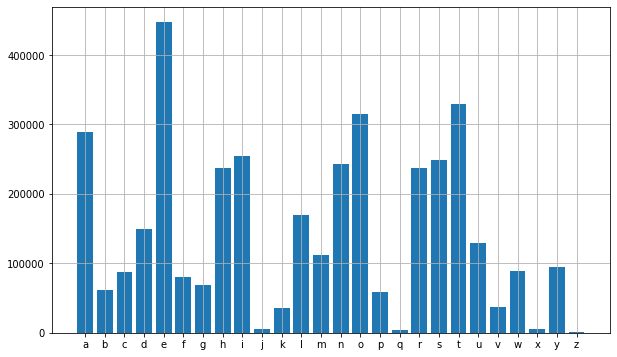

In [6]:
plot_distribution(shakespeare)

In [7]:
enigma = EnigmaMachine(settings)
encrypted = enigma.encode(shakespeare)

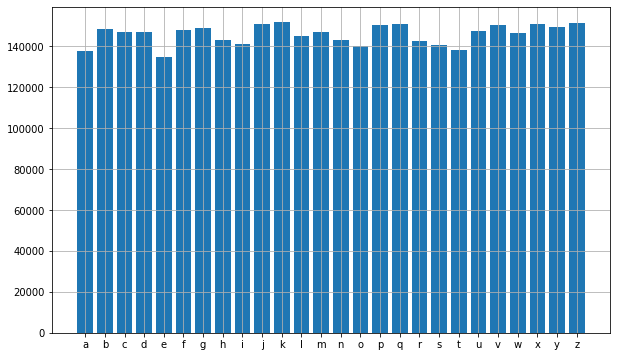

In [8]:
plot_distribution(encrypted)

In [9]:
enigma = EnigmaMachine(settings)
decrypted = enigma.encode(encrypted)

In [10]:
assert decrypted == shakespeare